In [101]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
from tensorflow.python import keras
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.applications import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Input
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
import zipfile
import seaborn as sns
from os import listdir, makedirs


Using TensorFlow backend.


In [0]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=71e28413bff6cc3734727722729746a961e267b9ddc6055d8ce6825e11077718
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
#import wget
data_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/7327/861871/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1589312032&Signature=lacicl%2BODFR86lw0g8ZtYuHCTaFzetPI1tL5MzkzqLt4xD%2B38bhji9YeLOVW%2BdI9Fi087WqMD5Nyoh5YV5D7o5nW95c6BeHFZ%2Ff%2BtD8nerQOO9G%2FThlKrTqj%2BRIWZJZr6lRjhIoHioJb056c46tz7YC%2BfD94Av7C5ok8WJ7s%2FHowQMh11DASpowcGBoDe0msWEmc4WAlwEQgCK%2F5chFIzm88BkTbV7yrL1b7tAmjvi36bFQiFRPVfXOUtQX3wvJZIMHeQe7cpayvQaDDNZF9MXti7CpekEUWz3lBEzHOaRe9cEwHKq%2Boli9KsAhP8KuKp3iEJOV2eTWEugCAWIzVSA%3D%3D&response-content-disposition=attachment%3B+filename%3Ddog-breed-identification.zip'
local_zip = '/content/gdrive/My Drive/Dog Breed/Dog-Breed-Identification.zip'
#wget.download(data_url, local_zip)  


In [0]:
data = zipfile.ZipFile(local_zip, 'r')
data.extractall('/content/Dog breed')
data.close()

In [16]:
def append_ext(fn):
    return fn+".jpg"
labels = pd.read_csv('/content/Dog breed/labels.csv', dtype=str)
testdf = pd.read_csv('/content/Dog breed/sample_submission.csv', dtype=str)
print(len(listdir('/content/Dog breed/train')), len(labels))
print(len(listdir('/content/Dog breed/test')), len(testdf))
labels["id"]=labels["id"].apply(append_ext)
testdf["id"]=testdf["id"].apply(append_ext)
labels.head()

10222 10222
10357 10357


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [45]:
df = pd.read_csv('/content/Dog breed/labels.csv')
df1 = df['breed']
df2 = df["id"]
df1 = pd.get_dummies(df1)
df = pd.concat([df2,df1], axis=1)
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000bec180eb18c7604dcecc8fe0dba07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,001513dfcb2ffafc82cccf4d8bbaba97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,001cdf01b096e06d78e9e5112d419397,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00214f311d5d2247d5dfe4fe24b2303d,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0021f9ceb3235effd7fcde7f7538ed62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


There are 120 breed


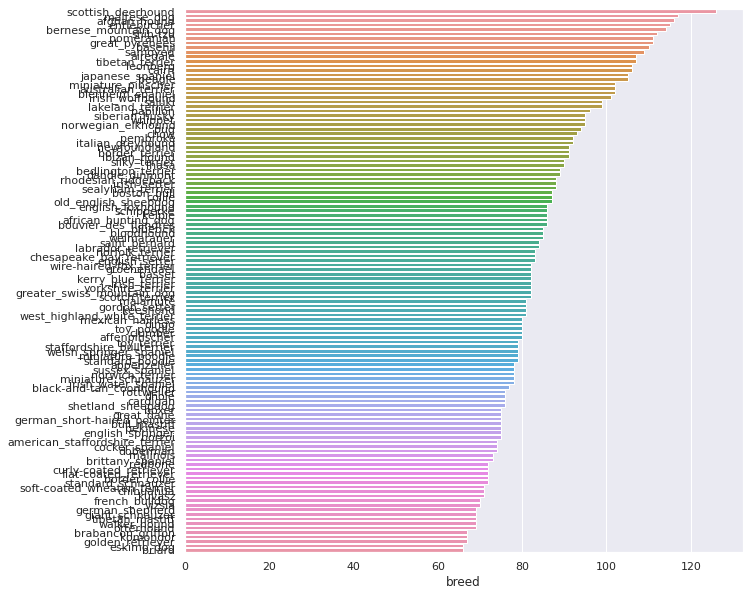

Number of Breed:  120
{'boston_bull': 0, 'dingo': 1, 'pekinese': 2, 'bluetick': 3, 'golden_retriever': 4, 'bedlington_terrier': 5, 'borzoi': 6, 'basenji': 7, 'scottish_deerhound': 8, 'shetland_sheepdog': 9, 'walker_hound': 10, 'maltese_dog': 11, 'norfolk_terrier': 12, 'african_hunting_dog': 13, 'wire-haired_fox_terrier': 14, 'redbone': 15, 'lakeland_terrier': 16, 'boxer': 17, 'doberman': 18, 'otterhound': 19, 'standard_schnauzer': 20, 'irish_water_spaniel': 21, 'black-and-tan_coonhound': 22, 'cairn': 23, 'affenpinscher': 24, 'labrador_retriever': 25, 'ibizan_hound': 26, 'english_setter': 27, 'weimaraner': 28, 'giant_schnauzer': 29, 'groenendael': 30, 'dhole': 31, 'toy_poodle': 32, 'border_terrier': 33, 'tibetan_terrier': 34, 'norwegian_elkhound': 35, 'shih-tzu': 36, 'irish_terrier': 37, 'kuvasz': 38, 'german_shepherd': 39, 'greater_swiss_mountain_dog': 40, 'basset': 41, 'australian_terrier': 42, 'schipperke': 43, 'rhodesian_ridgeback': 44, 'irish_setter': 45, 'appenzeller': 46, 'bloodh

In [18]:
# Build a dataframe with the number of instances in each class
breed_distrib = labels['breed'].value_counts()
breed_count = len(set(labels['breed']))
breed_distrib.columns = ['breed', 'number']
print(f"There are {breed_count} breed")
# Horizontal bar plot
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.set(font_scale=1)
ax = sns.barplot(breed_distrib,breed_distrib.index)
plt.show()
breed = labels["breed"].unique()
print("Number of Breed: ", len(breed))
breed2id = {name: i for i, name in enumerate(breed)}
id2breed = {i: name for i, name in enumerate(breed)}
print(breed2id)

## Flow from Dataframe

In [0]:
datagen = ImageDataGenerator(rescale=1./255.,
                             horizontal_flip=True,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             validation_split=0.2)

In [20]:
image_size = 299
train_dir = '../content/Dog breed/train/'
train_generator=datagen.flow_from_dataframe(
                        dataframe=labels,
                        directory=train_dir,
                        x_col="id",
                        y_col="breed",
                        subset="training",
                        batch_size=8,
                        seed=50,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(image_size, image_size))


Found 8178 validated image filenames belonging to 120 classes.


In [21]:
train_dir = '../content/Dog breed/train/'

valid_generator=datagen.flow_from_dataframe(
                        dataframe=labels,
                        directory=train_dir,
                        x_col="id",
                        y_col="breed",
                        subset="validation",
                        batch_size=8,
                        seed=42,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(image_size, image_size))

Found 2044 validated image filenames belonging to 120 classes.


In [23]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_dir = '../content/Dog breed/test/'
test_generator=test_datagen.flow_from_dataframe(
                            dataframe=testdf,
                            directory=test_dir,
                            x_col="id",
                            y_col=None,
                            batch_size=1,
                            seed=42,
                            shuffle=False,
                            class_mode=None,
                            target_size=(image_size, image_size))

Found 10357 validated image filenames.


## Model

In [0]:
inputs = Input((299, 299, 3))
backbone = Xception(input_tensor=inputs, include_top=False, weights="imagenet")
backbone.trainable = False
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation="relu")(x)
x = Dense(120, activation="softmax")(x)

model = Model(inputs, x)
lr = 1e-4
optimizer = Adam(lr)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [25]:
STEP_SIZE_TRAIN=train_generator.n//8
STEP_SIZE_VALID=valid_generator.n//8
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

1022
255


## Training

In [0]:
filepath="/content/gdrive/My Drive/Dog Breed/" + "weights.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,
                  shuffle = True, callbacks=callbacks_list)

Epoch 1/20
1022/1022 [==============================] - 365s 357ms/step - loss: 1.9103 - accuracy: 0.5510 - val_loss: 1.6900 - val_accuracy: 0.7706

Epoch 00001: val_loss improved from inf to 1.69003, saving model to /content/gdrive/My Drive/Dog Breed/weights.h5
Epoch 2/20
1022/1022 [==============================] - 355s 347ms/step - loss: 0.6425 - accuracy: 0.8100 - val_loss: 0.8368 - val_accuracy: 0.7824

Epoch 00002: val_loss improved from 1.69003 to 0.83682, saving model to /content/gdrive/My Drive/Dog Breed/weights.h5
Epoch 3/20
1022/1022 [==============================] - 354s 346ms/step - loss: 0.4184 - accuracy: 0.8681 - val_loss: 1.3180 - val_accuracy: 0.7711

Epoch 00003: val_loss did not improve from 0.83682
Epoch 4/20
1022/1022 [==============================] - 354s 346ms/step - loss: 0.2808 - accuracy: 0.9141 - val_loss: 1.7660 - val_accuracy: 0.7618

Epoch 00004: val_loss did not improve from 0.83682
Epoch 5/20
1022/1022 [==============================] - 353s 346ms/ste

In [0]:
scores = model.evaluate_generator(generator=valid_generator)
print("Accuracy = ", scores[1])

Accuracy =  0.7137964963912964


In [0]:
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1)

10357/10357 [==============================] - 165s 16ms/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
predicted_class_indices

array([61, 94, 31, ..., 36, 73, 59])

In [0]:
labelss = dict((v,k) for k,v in labelss.items())
predictions = [labelss[k] for k in predicted_class_indices]

In [0]:
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("../content/gdrive/My Drive/Dog Breed/results.csv",index=False)

## Test

In [111]:
from os.path import join
from keras.applications import Xception


image_dir = 'F:/Projects/Dog Breed Classifier'
img_paths = [join(image_dir, filename) for filename in 
                           ['g.jpg']]

import numpy as np
from tensorflow.python.keras.applications.xception import preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

image_size = 299

def read_and_prep_images(img_paths, img_height=299, img_width=299):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    output = preprocess_input(img_array)
    return(output)

model.load_weights('F:/Projects/Dog Breed Classifier/weights.h5')
test_data = read_and_prep_images(img_paths)
preds = model.predict(test_data)
my_file = open("classes.txt", "r")
content = my_file.read()
content_list = content.rsplit()
my_file.close()
print(content_list[reds.argmax()])

african_hunting_dog


In [108]:
my_file = open("classes.txt", "r")
content = my_file.read()
content_list = content.rsplit()
my_file.close()
print(content_list)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

In [109]:
content_list[preds.argmax()]

'german_shepherd'